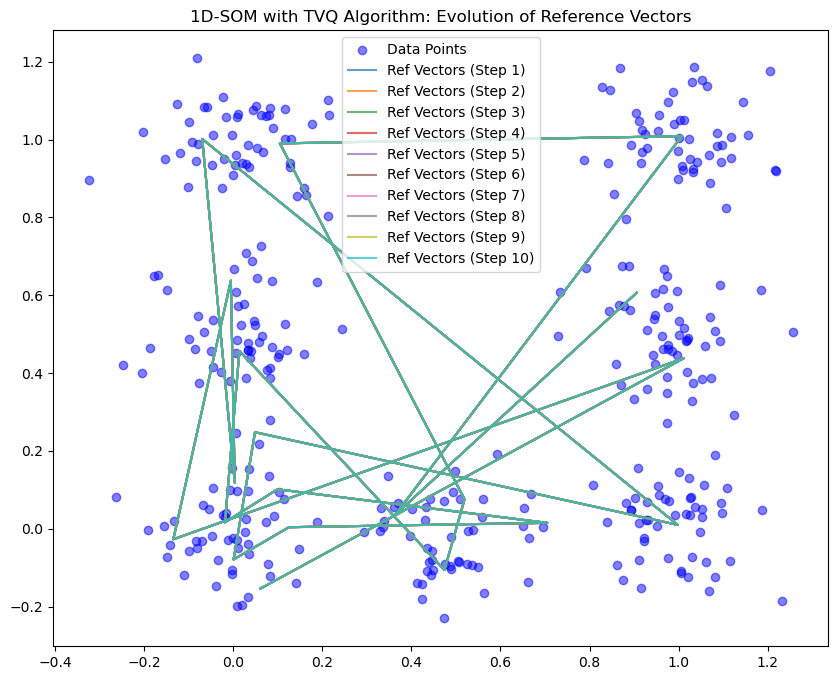

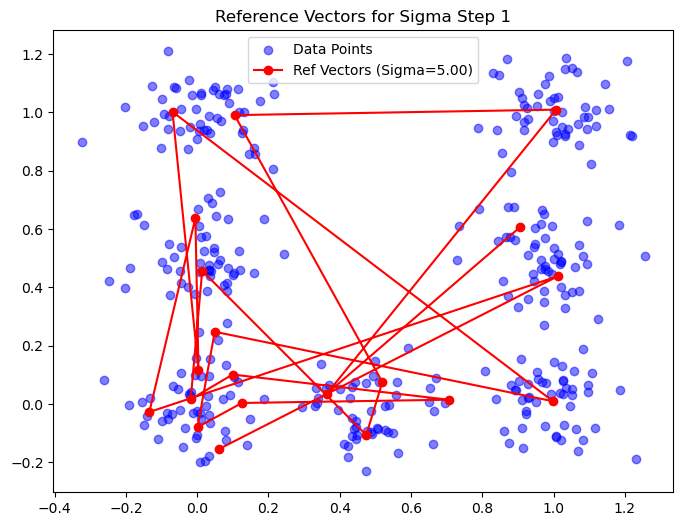

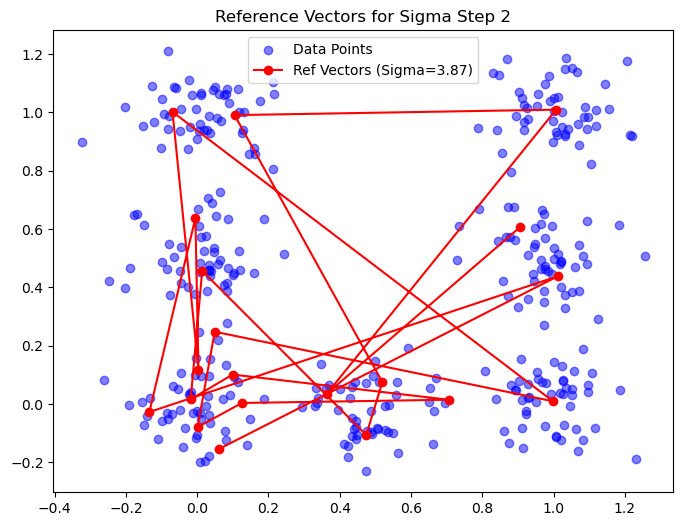

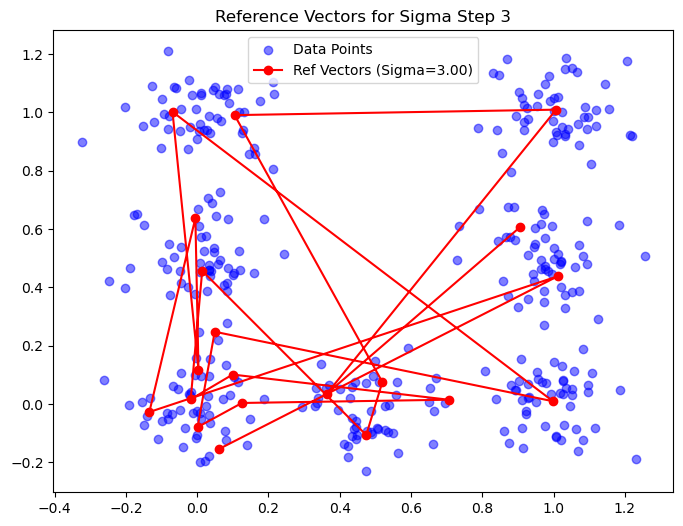

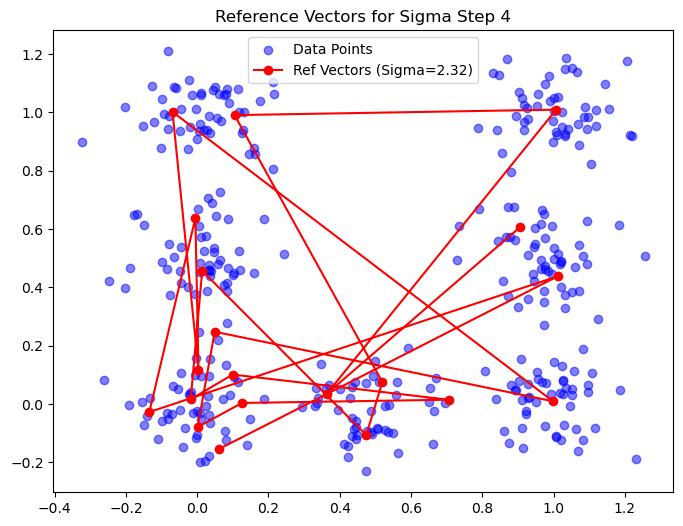

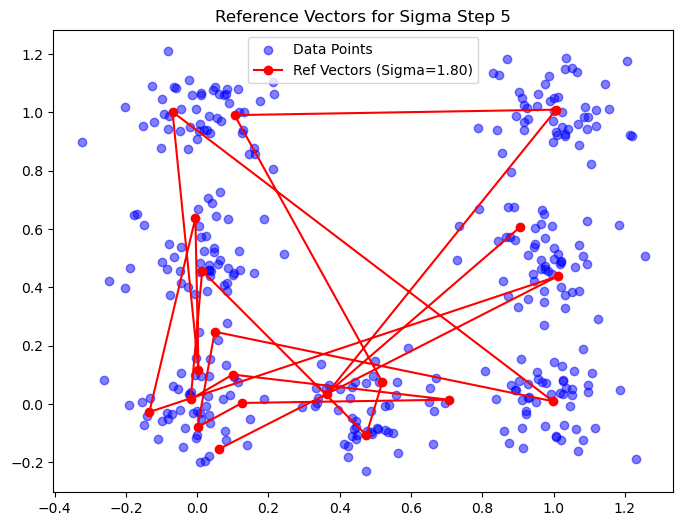

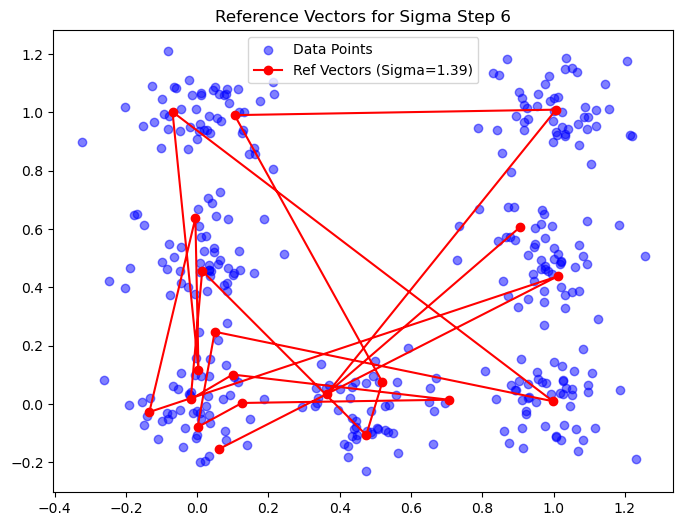

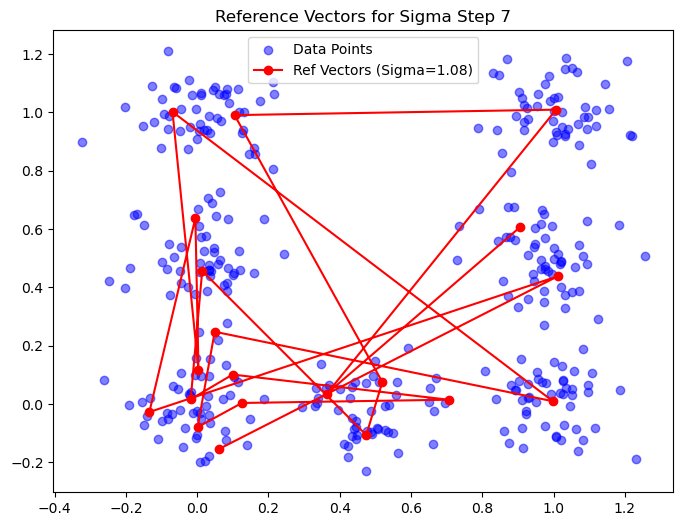

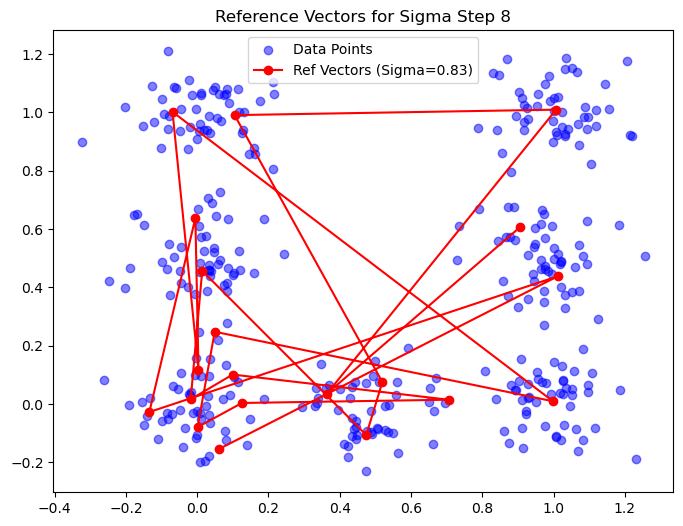

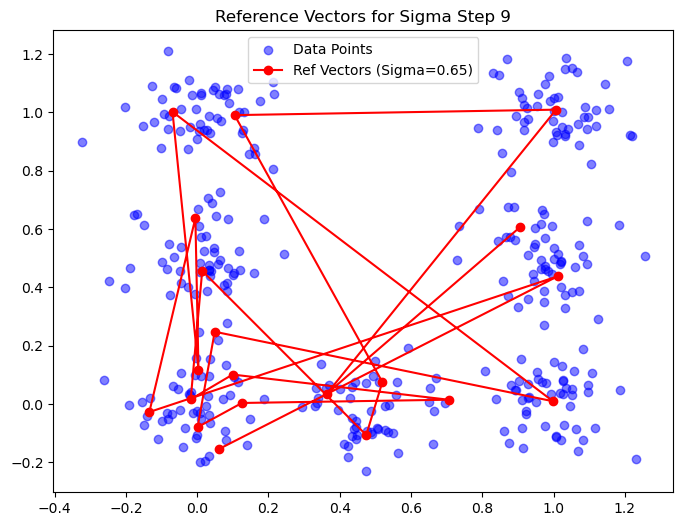

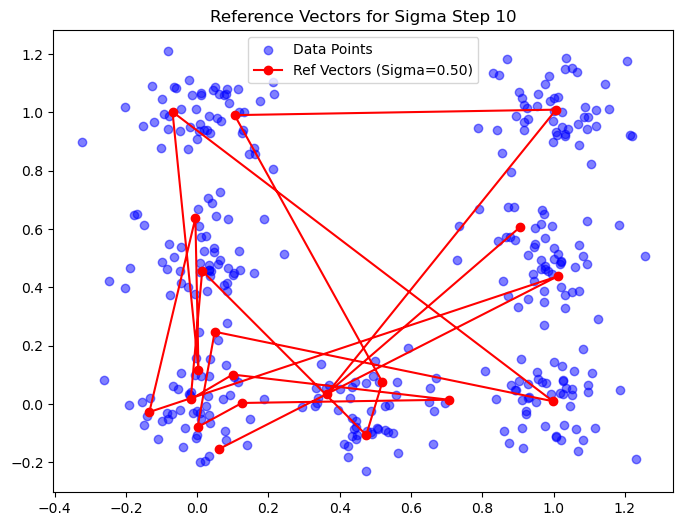

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
K = 20  # Number of prototypes
n_clusters = 7  # Number of clusters
cluster_centers = [(0, 0), (1, 0), (0, 1), (1, 1), (0.5, 0), (0, 0.5), (1, 0.5)]
std_dev = 0.1  # Standard deviation of clusters
n_points_per_cluster = 50
N = n_clusters * n_points_per_cluster  # Total number of points

# Generate synthetic 2D dataset
data = []
for center in cluster_centers:
    cluster_data = np.random.normal(loc=center, scale=std_dev, size=(n_points_per_cluster, 2))
    data.append(cluster_data)
data = np.vstack(data)

# Initialize grid and reference vectors
np.random.seed(42)  # For reproducibility

grid_vec = np.linspace(0, 1, K)
ref_vectors = np.random.rand(K, 2)  # Random initialization

# Define sigma values
n_steps = 10
sigma_vec = 0.5 * np.logspace(1, 0, n_steps)

# Neighborhood function and confusion probabilities
def calculate_hmat(grid_vec, sigma):
    grid_diff = np.reshape(grid_vec, (K, 1)) - grid_vec
    h_mat = np.exp(-0.5 / sigma**2 * (grid_diff**2))
    return h_mat

# TVQ Algorithm - Tracking reference vector evolution
ref_vectors_evolution = []  # To store reference vectors for visualization
for sigma in sigma_vec:
    h_mat = calculate_hmat(grid_vec, sigma)
    prob_mat = h_mat / h_mat.sum(axis=0)

    prev_error = np.inf
    while True:
        # Assignment step
        distances = np.linalg.norm(data[:, np.newaxis, :] - ref_vectors, axis=2)  # N x K
        weighted_distances = np.sum(prob_mat.T[np.newaxis, :, :] * distances[:, :, np.newaxis], axis=2)
        assignments = np.argmin(weighted_distances, axis=1)

        # Update step
        new_ref_vectors = np.zeros_like(ref_vectors)
        for k in range(K):
            assigned_points = data[assignments == k]
            if len(assigned_points) > 0:
                new_ref_vectors[k] = np.mean(assigned_points, axis=0)

        # Check convergence
        error = np.linalg.norm(ref_vectors - new_ref_vectors)
        if np.abs(prev_error - error) < 1e-4:
            break
        ref_vectors = new_ref_vectors
        prev_error = error

    ref_vectors_evolution.append(ref_vectors.copy())

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], c='blue', label='Data Points', alpha=0.5)
for i, ref_vec in enumerate(ref_vectors_evolution):
    plt.plot(ref_vec[:, 0], ref_vec[:, 1], label=f'Ref Vectors (Step {i+1})', alpha=0.7)
plt.title("1D-SOM with TVQ Algorithm: Evolution of Reference Vectors")
plt.legend()
plt.show()

# Stepwise visualization for sigma evolution
for i, (sigma, ref_vec) in enumerate(zip(sigma_vec, ref_vectors_evolution)):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c='blue', label='Data Points', alpha=0.5)
    plt.plot(ref_vec[:, 0], ref_vec[:, 1], 'ro-', label=f'Ref Vectors (Sigma={sigma:.2f})')
    plt.title(f"Reference Vectors for Sigma Step {i+1}")
    plt.legend()
    plt.show()

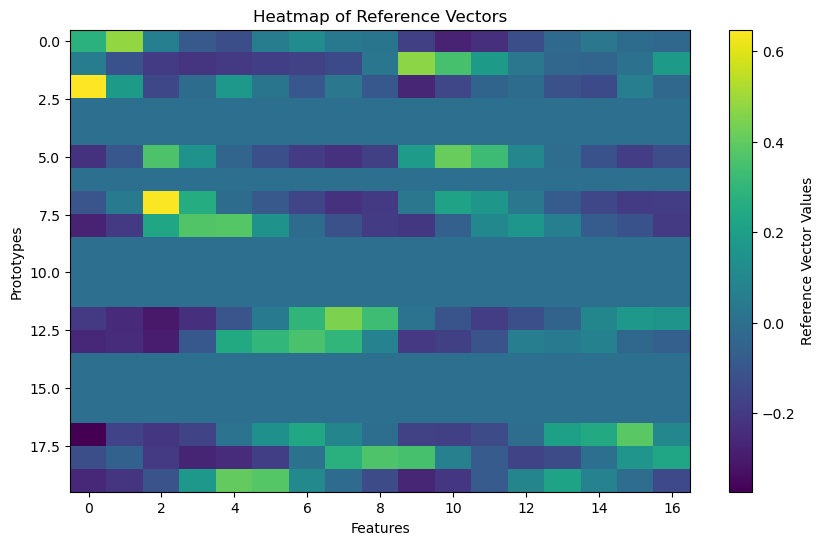

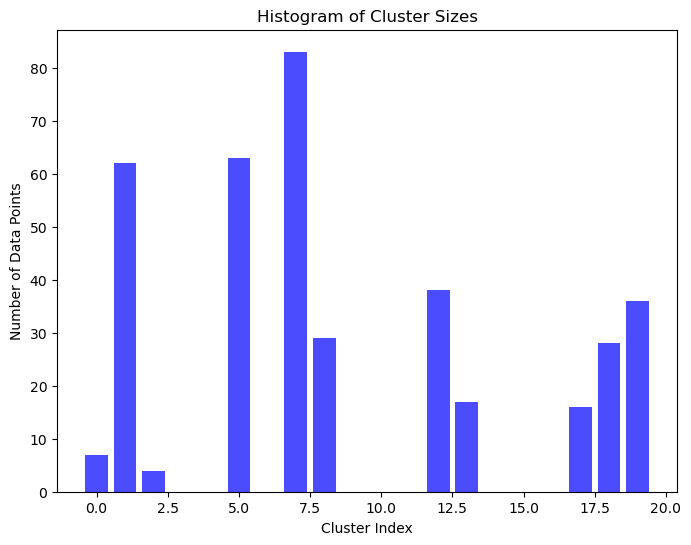

Cluster Sizes: [ 7 62  4  0  0 63  0 83 29  0  0  0 38 17  0  0  0 16 28 36]
Number of Empty Clusters: 9


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the gene expression data
data = pd.read_csv('GexprData.csv').values

# Parameters
K = 20  # Number of prototypes
np.random.seed(42)  # For reproducibility
n_steps = 10
sigma_vec = 0.5 * np.logspace(1, 0, n_steps)

# Initialize grid and reference vectors
grid_vec = np.linspace(0, 1, K)
ref_vectors = np.random.rand(K, data.shape[1])  # Random initialization based on feature dimension

# Neighborhood function and confusion probabilities
def calculate_hmat(grid_vec, sigma):
    grid_diff = np.reshape(grid_vec, (K, 1)) - grid_vec
    h_mat = np.exp(-0.5 / sigma**2 * (grid_diff**2))
    return h_mat

# TVQ Algorithm
ref_vectors_evolution = []  # To track reference vectors for visualization
assignments_evolution = []  # To track assignments
for sigma in sigma_vec:
    h_mat = calculate_hmat(grid_vec, sigma)
    prob_mat = h_mat / h_mat.sum(axis=0)

    prev_error = np.inf
    while True:
        # Assignment step
        distances = np.linalg.norm(data[:, np.newaxis, :] - ref_vectors, axis=2)  # N x K
        weighted_distances = np.sum(prob_mat.T[np.newaxis, :, :] * distances[:, :, np.newaxis], axis=2)
        assignments = np.argmin(weighted_distances, axis=1)

        # Update step
        new_ref_vectors = np.zeros_like(ref_vectors)
        for k in range(K):
            assigned_points = data[assignments == k]
            if len(assigned_points) > 0:
                new_ref_vectors[k] = np.mean(assigned_points, axis=0)

        # Check convergence
        error = np.linalg.norm(ref_vectors - new_ref_vectors)
        if np.abs(prev_error - error) < 1e-4:
            break
        ref_vectors = new_ref_vectors
        prev_error = error

    ref_vectors_evolution.append(ref_vectors.copy())
    assignments_evolution.append(assignments.copy())

# Visualize reference vectors as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(ref_vectors_evolution[-1], aspect='auto', cmap='viridis')
plt.colorbar(label='Reference Vector Values')
plt.title("Heatmap of Reference Vectors")
plt.xlabel("Features")
plt.ylabel("Prototypes")
plt.show()

# Histogram of cluster sizes
cluster_sizes = np.bincount(assignments_evolution[-1], minlength=K)
plt.figure(figsize=(8, 6))
plt.bar(range(K), cluster_sizes, color='blue', alpha=0.7)
plt.title("Histogram of Cluster Sizes")
plt.xlabel("Cluster Index")
plt.ylabel("Number of Data Points")
plt.show()

# Analysis of clusters
print("Cluster Sizes:", cluster_sizes)
print("Number of Empty Clusters:", np.sum(cluster_sizes == 0))

## **Part b: Synthetic 2D Dataset**

### 1. Does the U-shaped structure of the distribution map well?
- Yes, the U-shaped structure of the synthetic clusters is effectively captured in the final step, as shown in the visualization. The reference vectors adapt to align with the clusters as the `sigma` values decrease.

### 2. Can the U-shaped structure also be mapped with a shorter sequence of sigmas?
- A shorter sequence of `sigma` values might still map the U-shaped structure, but the smoothness and accuracy of the reference vectors aligning with the cluster centers may be compromised. Gradual reduction of `sigma` values enables better convergence.

### 3. Does optimizing the sequence of sigmas improve the results?
- Yes, optimizing the decay rate of `sigma` values can improve clustering performance by ensuring the reference vectors converge closer to the true cluster centers.

---

## **Part c: Gene Expression Data**

### 1. Is the heatmap of the reference vectors meaningful?
- The heatmap provides an overview of the final state of the reference vectors. Each row corresponds to a prototype, and each column represents a feature. The values indicate how well the prototypes summarize the data in the feature space.

### 2. What does the histogram of cluster sizes indicate?
- The histogram reveals the distribution of data points across the clusters. Some clusters are significantly larger, indicating they captured multiple data groups, while others are smaller or empty, suggesting those prototypes failed to align with any data points.

### 3. Is a smaller number of clusters recognizable or assumed?
- Based on the cluster size distribution, a smaller number of clusters could suffice to summarize the dataset. The presence of empty and sparsely populated clusters suggests that the initial choice of `K = 20` might be higher than necessary for this dataset.

---